In [1]:
import raccoon_ipm as rp
import numpy as np
import yaml
import scipy.stats as stats
import macroeco.models as md
reload(rp)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Simulating the Raccoon IBM model

This might be slow, but conceptually need to understand how it will work.

1. Infection and death occur on the weekly time-scale
2. Aging and reproduction occur on the monthly time scale

Conceptually, assume that we have 

In [2]:
# Load parameters
with open('ipm_params.yml') as f:
    # use safe_load instead load
    params = yaml.safe_load(f)

params['age_immunity'] = 10000
params['k_rodent'] = 0.2
params['egg_contact'] = 0.02

In [3]:
# Ensure clusters are started on separate nodes
import ipyparallel as ipp
rc = ipp.Client()
dv = rc[:]

# Import the necessary modules onto clusters
with dv.sync_imports():
    import numpy
    import raccoon_ipm

importing numpy on engine(s)
importing raccoon_ipm on engine(s)


In [6]:
rc.close()

In [24]:
reload(rp)

<module 'raccoon_ipm' from 'raccoon_ipm.pyc'>

In [4]:
max_age = 100
max_load = 101
S = rp.get_survival_matrix(params, max_load=max_load, max_age=max_age)

In [5]:
%%time
# Push necessary values to the clusters
nxt, cur = np.meshgrid(range(max_load + 1), range(max_load + 1))
dv.push(dict(params=params))

Gmat = []
for age in range(max_age):
    
    # This is what we want to parallelize over
    dv.scatter('dt', zip(nxt.ravel(), cur.ravel()))
    dv.push(dict(age=age))
    %px gmat4 = [raccoon_ipm._growth_fxn(tnxt, tcur, age, 10000, params) for tnxt, tcur in dt]
    Gmat.append(np.reshape(dv.gather('gmat4').get(), (len(nxt), len(nxt))).T)

CPU times: user 18.2 s, sys: 1.24 s, total: 19.4 s
Wall time: 3min 19s


In [42]:
%%time
Gmat_temp = rp.get_growth_matricies(params, max_age=1, max_load=101)

CPU times: user 1.4 s, sys: 420 ms, total: 1.82 s
Wall time: 1.73 s


In [41]:
np.all(Gmat_temp[0] == Gmat[0])

True

In [40]:
Gmat[0]

array([[  2.00000000e-001,   1.32109571e-002,   8.72519022e-004, ...,
          1.14998195e-118,   7.45409129e-120,   4.83108032e-121],
       [  1.60000000e-001,   2.02137051e-001,   2.60022339e-002, ...,
          1.65162736e-115,   1.08138113e-116,   7.07861023e-118],
       [  1.28000000e-001,   1.60730645e-001,   2.04135385e-001, ...,
          1.17407288e-112,   7.76549374e-114,   5.13453757e-115],
       ..., 
       [  5.09258994e-011,   3.54827048e-011,   2.46518827e-011, ...,
          3.58381556e-003,   1.35589248e-002,   3.58155818e-002],
       [  4.07407195e-011,   2.82143131e-011,   1.94805837e-011, ...,
          6.10220981e-004,   3.31307683e-003,   1.27478117e-002],
       [  3.25925756e-011,   2.24348022e-011,   1.53940836e-011, ...,
          1.03903128e-004,   5.50218471e-004,   3.06238766e-003]])

In [6]:
# Broadcast weekly survival prob across weekly growth
StimesG = [S[:, i]*Gmat[i] for i in range(max_age)]

# Get monthly survival and growth
StimesG_month = [np.linalg.matrix_power(StimesG[i], 4) for i in range(max_age)]

In [7]:
Gmat[i].sum(axis=0)

array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.  

In [8]:
# Apply each matrix to load-distribution in an age class.

# Initial load dists over age 
N_init = np.array([np.array([10] + [0]*max_load) for i in range(max_age)]).T
N_vals = [N_init]
months = 400

# Loop over months for projection
for j in range(months):
    
    # Project load-distributions forward 1 month
    N_up = np.array([np.dot(StimesG_month[i], N_vals[j][:, i]).ravel() for i in range(max_age)]).T

    # Reproduction
    age_vect = N_up.sum(axis=0)[:, np.newaxis]
    R = rp.get_repro_matrix(params, age_vect.sum(), max_age=max_age)
    new_raccoons = np.sum(R[0, :] * age_vect.ravel())
    new_class = np.array([new_raccoons] + [0]*max_load)[:, np.newaxis]

    # Fully updated age-dependent and load-dependent vector
    N_up2 = np.concatenate([new_class, N_up[:, 0:-1]], axis=1)
    N_vals.append(N_up2)

In [58]:
len(N_vals)

401

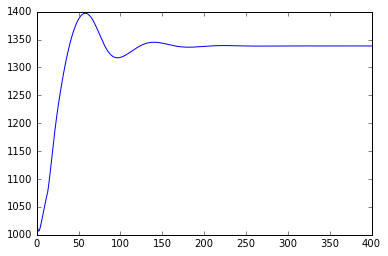

In [9]:
plot([N_vals[i].sum() for i in range(months + 1)])

In [10]:
mean_prof = np.array([np.sum((racs / np.sum(racs))*np.arange(max_load + 1)) for racs in N_vals[months].T])
mom2_prof = np.array([np.sum((racs / np.sum(racs))*np.arange(max_load + 1)**2) for racs in N_vals[months].T])
var_prof = mom2_prof - mean_prof**2
prev_prof = [1 - (racs[0] / np.sum(racs)) for racs in N_vals[months].T]

In [11]:
age_dist = N_vals[months].sum(axis=0) / np.sum(N_vals[months])
age_struct = N_vals[months].sum(axis=0)

In [65]:
age_dist

array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.22158971e-03,   7.22866821e-03,   1.46371749e-02, ...,
          5.85346105e-12,   4.38625770e-12,   3.36353005e-12],
       [  1.21050946e-05,   8.03932284e-05,   2.98260294e-04, ...,
          6.09297791e-13,   4.47228574e-13,   3.34238773e-13],
       ..., 
       [  1.04282455e-01,   2.01128626e-01,   2.20336997e-01, ...,
          7.79463959e-34,   3.56760425e-34,   1.63591398e-34],
       [  1.04282455e-01,   2.01128626e-01,   2.20336997e-01, ...,
          7.79463959e-34,   3.56760425e-34,   1.63591398e-34],
       [  1.04282455e-01,   2.01128626e-01,   2.20336997e-01, ...,
          7.79463958e-34,   3.56760425e-34,   1.63591398e-34]])

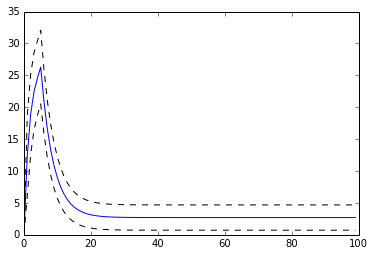

In [61]:
plot(mean_prof)
plot(mean_prof + np.sqrt(var_prof), '--', color="black")
plot(mean_prof - np.sqrt(var_prof), '--', color="black")

In [63]:
age_dist

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

(0, 1.1)

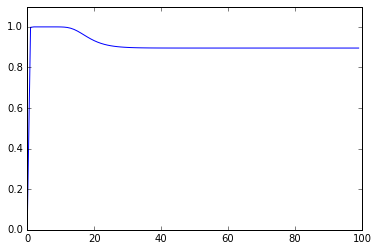

In [321]:
plot(prev_prof)
plt.ylim(0, 1.1)

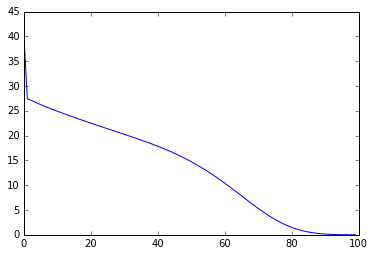

In [322]:
plot(N_vals[months].sum(axis=0))

In [18]:
# Relative R0
reload(rp)
with open('ipm_params.yml') as f:
    # use safe_load instead load
    params = yaml.safe_load(f)

params['age_immunity'] = 10000
params['k_rodent'] = 0.2
params['egg_contact'] = 0.02
age_dist = N_vals[months].sum(axis=0) / np.sum(N_vals[months])
R0_rel = rp.relative_R0(params, max_age=100)
avg_R0 = np.sum(age_dist * R0_rel)
avg_lnR0 = np.sum(age_dist * np.log(np.array(R0_rel) + 1))

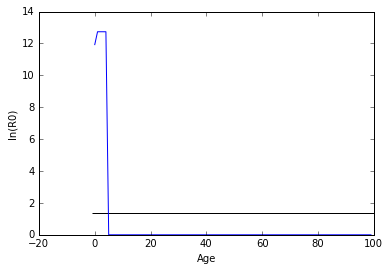

In [19]:
plot(np.log(np.array(R0_rel) + 1))
plt.xlabel("Age")
plt.ylabel("ln(R0)")
plt.hlines(avg_lnR0, -1, 100)

In [20]:
R0_rel

[151529.65298182599,
 339809.16826268513,
 339809.16641573125,
 339809.15384452994,
 339809.10731322342,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [59]:
# Exact R0?
# Relative R0
reload(rp)
with open('ipm_params.yml') as f:
    # use safe_load instead load
    params = yaml.safe_load(f)

params['age_immunity'] = 0.5
params['k_latrine'] = 1
params['egg_contact'] = 0.002
params['egg_death_rate'] = 1000
R0_res = rp.full_R0(params, age_struct)

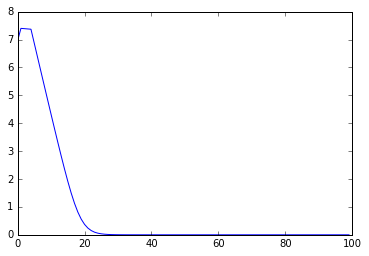

In [60]:
plot(np.log(np.diag(R0_res[1]) + 1))

In [14]:
age_struct

array([  4.02069080e+01,   2.74149377e+01,   2.71320017e+01,
         2.68415815e+01,   2.65448976e+01,   2.62431632e+01,
         2.59505060e+01,   2.56786334e+01,   2.54164898e+01,
         2.51598338e+01,   2.49069591e+01,   2.46571322e+01,
         2.44100053e+01,   2.41653870e+01,   2.39231483e+01,
         2.36831838e+01,   2.34453926e+01,   2.32096697e+01,
         2.29759008e+01,   2.27439589e+01,   2.25137023e+01,
         2.22849721e+01,   2.20575908e+01,   2.18313606e+01,
         2.16060620e+01,   2.13814521e+01,   2.11572637e+01,
         2.09332034e+01,   2.07089510e+01,   2.04841582e+01,
         2.02584478e+01,   2.00314131e+01,   1.98026169e+01,
         1.95715919e+01,   1.93378407e+01,   1.91008357e+01,
         1.88600206e+01,   1.86148113e+01,   1.83645978e+01,
         1.81087469e+01,   1.78466050e+01,   1.75775021e+01,
         1.73007569e+01,   1.70156817e+01,   1.67215898e+01,
         1.64178027e+01,   1.61036591e+01,   1.57785246e+01,
         1.54418033e+01,